Text(0.5,1,'undistorted/wrapped Image')

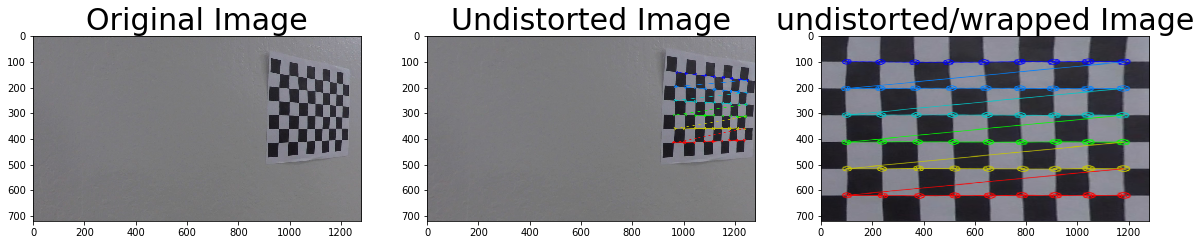

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import glob
%matplotlib inline

#first part of the rubric, chessboard files.


# prepare object points
nx = 9
ny = 6


def calc_objimg_points(images,nx,ny):
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    return objpoints, imgpoints
    
    
def undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist =  cv2.undistort(img, mtx, dist, None, mtx)
    return undist


def corners_unwarp(img,nx, ny): 
    # function as from the lesson, with small modification
    
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        offset = 100 # offset for dst points
        img_size = img.shape[1::-1]

        # For source points I'm grabbing the four detected corners, and for
        # dst points in the corners of the image (with 100 offset)
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(img, M, img_size)
    else: #could not find, so return 
        # a few images don't have all the corners in the picture
        print("could not find corners, so returning orginal image")
        warped=img
        M=None
    # Return the resulting image and matrix
    return warped, M


#load multiple pictures to get distort data
images = glob.glob('camera_cal/*.jpg')
objpoints, imgpoints = calc_objimg_points(images,nx,ny)
image = cv2.imread(images[np.random.randint(len(images)-1)])
#change color is not really needed, kinda b/w anyway
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist = undistort(image, objpoints, imgpoints)
unwrapedImage, m =  corners_unwarp(undist,nx, ny)

# Visualize undistortion      
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
ax3.imshow(unwrapedImage)
ax3.set_title('undistorted/wrapped Image', fontsize=30)

True

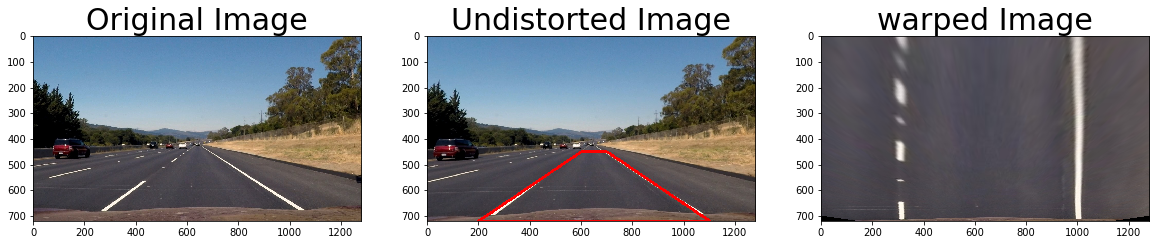

In [2]:
#second part
#Here we read the test image and apply the undist calculated in part 1.
#Then we draw some lines that will be used to wrap it.
def corners_unwarp_road(img,invert=False):
    src=np.float32([[200,720],[594,450],[686,450],[1080,720]])
    dst=np.float32([[300,720],[300,100],[980,100],[980,720]])
    #dst=np.float32([[400,720],[400,100],[880,100],[880,720]])
    if invert:
        M = cv2.getPerspectiveTransform(dst, src)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = img.shape[1::-1]
    warped = cv2.warpPerspective(img, M, img_size)
    return warped
    
#images = glob.glob('test_images/*.jpg')
#images  = cv2.imread(images)#[np.random.randint(len(images)-1)])
#read all files and convert to rgb
images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob('test_images/*.jpg')]
imageIndex=np.random.randint(len(images))
undist=np.zeros_like(images)
for i,image in enumerate(images):
    undist[i] = undistort(image, objpoints, imgpoints)



src=np.array([[200,720],[1100,720],[700,450],[600,450]], np.int32)
src = src.reshape((-1,1,2))
undist_line=cv2.polylines(undist[imageIndex].copy(), [src], True,(255,0,0),thickness=10)  
warped=corners_unwarp_road(undist[imageIndex])
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(images[imageIndex])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_line)
cv2.imwrite("undist.jpg",cv2.cvtColor(undist_line, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)
ax3.imshow(warped)
ax3.set_title('warped Image', fontsize=30)
cv2.imwrite("warp.jpg",cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

In [3]:
# Third part, use images above and apply sobel and some other stuff to
# create a binary image. we use an interact to play around and faster try new threshold values.
# Unfortunatly I don't have so much time left so cant try to many different.
# Another better method would be to use ml to come up with better values.

from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
from ipywidgets import widgets

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output
def test(ksize,xthresh_min,xthresh_max,ythresh_min,ythresh_max,magthresh_min,
         magthresh_max,dirthresh_min,dirthresh_max,s_thresh_min,s_thresh_max):

    images=undist
    for image in images:
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        gray = image[:,:,0]#cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)# keep only red

        # Apply each of the thresholding functions
        gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(xthresh_min, xthresh_max))
        grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(ythresh_min, ythresh_max))
        mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(magthresh_min, magthresh_max))
        dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(dirthresh_min, dirthresh_max))



        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
        gradyx = np.zeros_like(dir_binary)
        gradyx[((gradx == 1) & (grady == 1))] = 1
        magdir = np.zeros_like(dir_binary)
        magdir[(mag_binary == 1) & (dir_binary == 1)] = 1
        combined = np.zeros_like(dir_binary)
        combined[(gradyx ==1 ) | (magdir == 1) | (s_binary == 1)] = 1
        #combined = np.uint8(255*combined/np.max(combined))
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40,20))
        gradyx=corners_unwarp_road(gradyx.astype(np.uint8))
        ax1.imshow(gradyx, cmap='gray')
        ax1.set_title('x', fontsize=10)
        
        magdir=corners_unwarp_road(magdir.astype(np.uint8))
        ax2.imshow(magdir, cmap='gray')
        ax2.set_title('y', fontsize=10)
        
        s_binary=corners_unwarp_road(s_binary.astype(np.uint8))
        ax3.imshow(s_binary, cmap='gray')
        ax3.set_title('s', fontsize=10)


        combined=corners_unwarp_road(combined.astype(np.uint8))
        ax4.imshow(combined, cmap='gray')
        ax4.set_title('comb', fontsize=10)

    
    
    #gray = cv2.cvtColor(, cv2.COLOR_RGB2GRAY)#
    #sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    #abs_sobelx = np.absolute(sobelx)
    #scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #thresh_min = 20
    #thresh_max = 255
    #sxbinary = np.zeros_like(scaled_sobel)
    #sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #plt.imshow(sxbinary, cmap='gray'

interact_manual(test,ksize=widgets.IntSlider(min=1,max=31,step=2,value=9)
    ,xthresh_min=widgets.IntSlider(min=1,max=255,step=1,value=30)
    ,xthresh_max=widgets.IntSlider(min=1,max=255,step=1,value=230)
    ,ythresh_min=widgets.IntSlider(min=1,max=255,step=1,value=30)
    ,ythresh_max=widgets.IntSlider(min=1,max=255,step=1,value=230)
    ,magthresh_min=widgets.IntSlider(min=1,max=255,step=1,value=30)
    ,magthresh_max=widgets.IntSlider(min=1,max=255,step=1,value=150)
    ,dirthresh_min=widgets.FloatSlider(min=0,max=np.pi,step=np.pi/20,value=0.7)
    ,dirthresh_max=widgets.FloatSlider(min=0,max=np.pi,step=np.pi/20,value=1.3)
    ,s_thresh_min=widgets.IntSlider(min=1,max=255,step=1,value=80)
    ,s_thresh_max=widgets.IntSlider(min=1,max=255,step=1,value=255))

        #,ksize=widgets.IntSlider(min=1,max=255,step=1,value=1)
        #,ksize=widgets.IntSlider(min=1,max=255,step=1,value=1));
        
def test2(ksize,xthresh_min,xthresh_max,ythresh_min,ythresh_max):
    def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
        #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

        # Return the result
        return binary_output
    images=undist[0]
    gray = image[:,:,0]#cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)# keep only red

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(xthresh_min, xthresh_max))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(ythresh_min, ythresh_max))

    gradyx = np.zeros_like(grady)
    gradyx[((gradx == 1) & (grady == 1))] = 1
    #combined = np.uint8(255*combined/np.max(combined))
    f, (ax1) = plt.subplots(1, 1, figsize=(40,20))
    gradyx=corners_unwarp_road(gradyx.astype(np.uint8))
    ax1.imshow(gradyx, cmap='gray')
    ax1.set_title('x', fontsize=10)
    
interact_manual(test2,ksize=widgets.IntSlider(min=1,max=31,step=2,value=9)
    ,xthresh_min=widgets.IntSlider(min=1,max=255,step=1,value=30)
    ,xthresh_max=widgets.IntSlider(min=1,max=255,step=1,value=230)
    ,ythresh_min=widgets.IntSlider(min=1,max=255,step=1,value=30)
    ,ythresh_max=widgets.IntSlider(min=1,max=255,step=1,value=230));

#9,30,230,30,230,30,150,0.7,1.3,80,255

interactive(children=(IntSlider(value=9, description='ksize', max=31, min=1, step=2), IntSlider(value=30, description='xthresh_min', max=255, min=1), IntSlider(value=230, description='xthresh_max', max=255, min=1), IntSlider(value=30, description='ythresh_min', max=255, min=1), IntSlider(value=230, description='ythresh_max', max=255, min=1), IntSlider(value=30, description='magthresh_min', max=255, min=1), IntSlider(value=150, description='magthresh_max', max=255, min=1), FloatSlider(value=0.7, description='dirthresh_min', max=3.141592653589793, step=0.15707963267948966), FloatSlider(value=1.3, description='dirthresh_max', max=3.141592653589793, step=0.15707963267948966), IntSlider(value=80, description='s_thresh_min', max=255, min=1), IntSlider(value=255, description='s_thresh_max', max=255, min=1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

interactive(children=(IntSlider(value=9, description='ksize', max=31, min=1, step=2), IntSlider(value=30, description='xthresh_min', max=255, min=1), IntSlider(value=230, description='xthresh_max', max=255, min=1), IntSlider(value=30, description='ythresh_min', max=255, min=1), IntSlider(value=230, description='ythresh_max', max=255, min=1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [4]:
#part 3.5
#basicly same as above but witout interact:
def getBinaryWarp(image,ksize,xthresh_min,xthresh_max,ythresh_min,ythresh_max,magthresh_min,
         magthresh_max,dirthresh_min,dirthresh_max,s_thresh_min,s_thresh_max):

    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = image[:,:,0]#cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)# keep only red

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(xthresh_min, xthresh_max))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(ythresh_min, ythresh_max))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(magthresh_min, magthresh_max))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(dirthresh_min, dirthresh_max))



    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    gradyx = np.zeros_like(dir_binary)
    gradyx[((gradx == 1) & (grady == 1))] = 1
    
    magdir = np.zeros_like(dir_binary)
    magdir[(mag_binary == 1) & (dir_binary == 1)] = 1
    
    combined = np.zeros_like(dir_binary)
    combined[(gradyx ==1 ) | (magdir == 1) | (s_binary == 1)] = 1
    
    return corners_unwarp_road(combined.astype(np.uint8))

(720,)
220,648,460,720
[43 44 20 33 34 35 51 52 53 54 55 19 23 24 25 27 28 29 30 31 32 40 41 42 43
 44 45 46 47 48 49 50 51 52 13 14 15 16 17 18 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 36 37 38 39 40 41 42 43 44 45 11 12 13 14 15 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 39 40 41 42 43 15 16 17 18 19 20 21 23 24 25 26
 27 38 13 14 15 16 17 20 21 22 17 18 19 38 36 37 47 43 36 53 54 55 56 57 58
 39]
[20 21 22 ..., 21 22 23]
[43 44 20 ..., 21 22 23]
219,578,459,650
[ 2  3  4 ...,  8 30 31]
[ 5  6 11 ..., 57 58 59]
[ 2  3  4 ..., 57 58 59]
222,504,462,576
[32 33 34 ..., 57 58 59]
[ 0  1  2 ..., 56 57 58]
[32 33 34 ..., 56 57 58]
242,430,482,502
[59 58 59 57 58 59 56 57 43 53 41 42 43 51 52 53 39 40 41 42 50 51 52 39 40
 49 50 48]
[ 0  1  2 ..., 57 58 59]
[59 58 59 ..., 57 58 59]
218,368,458,440
[32 30 31 32 28 29 30 31 27 28 29 30 31 26 27 28 29 26 27 28 25 26 27 25]
[ 4  5  6 ..., 57 58 59]
[32 30 31 ..., 57 58 59]
227,280,467,352
[11 12 13 ..., 18 19 20]
[ 0  1  2 ..., 57 58 59]
[

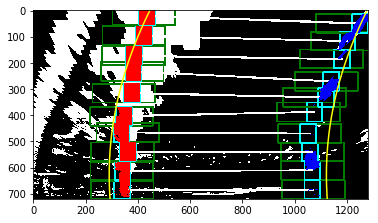

In [119]:
#This is old, keep for now

#part 4. find the lanes from the binary images
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image

#moved this here, maybe change place
ploty = np.linspace(0, images[0].shape[0]-1, images[0].shape[0] )
print(np.shape(ploty))
# Define conversions in x and y from pixels space to meters
ym_per_pix = 40/720. # meters per pixel in y dimension
xm_per_pix = 3.7/720. # meters per pixel in x dimension



def laneFinder_old(image):
    global xm_per_pix

    
    binary_warped = image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    lane_width=rightx_base-leftx_base
    
    xm_per_pix = (3.7/lane_width + xm_per_pix)/2 #should be more exact?
    
    # Set the width of the windows +/- margin
    margin = 120
    # Set minimum number of pixels found to recenter window
    minpix = 10
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    left_sum=0
    right_sum=0
    
    y_diff=0
    # Step through the windows one by one
    diffLOld=0
    diffROld=0
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        #win_y_low = binary_warped.shape[0] - ((window+1)*window_height)
        #win_y_high = binary_warped.shape[0] - (window*window_height)
        win_y_lowL = np.int(binary_warped.shape[0] - ((window+1)*window_height+y_diff))
        win_y_highL = np.int(binary_warped.shape[0] - (window*window_height+y_diff))
        win_y_low = np.int(binary_warped.shape[0] - ((window+1)*window_height-y_diff))
        win_y_high = np.int(binary_warped.shape[0] - (window*window_height-y_diff))
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        print(f"{win_xleft_low},{win_y_lowL},{win_xleft_high},{win_y_highL}")
        cv2.rectangle(out_img,(win_xleft_low,win_y_lowL),(win_xleft_high,win_y_highL),(0,123,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,123,0), 5) 
        pt1=((win_xleft_high+win_xleft_low)//2,(win_y_highL+win_y_lowL)//2)
        pt2=((win_xright_high+win_xright_low)//2,(win_y_high+win_y_low)//2)
        cv2.line(out_img,pt1,pt2,(255,255,255),5)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_lowL) & (nonzeroy < win_y_highL) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        #    left_lane_inds.append(good_left_inds)
        #    right_lane_inds.append(good_right_inds)   
        if False:
        # If you found > minpix pixels, recenter next window on their mean position
        
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        else:
            
            if len(good_left_inds) > minpix or len(good_right_inds) > minpix:
                if len(good_left_inds) > 0:
                    left_diff = np.int(np.mean(nonzerox[good_left_inds])) - leftx_current 
                else:
                    left_diff = 0

                if len(good_right_inds) > 0:
                    right_diff =  np.int(np.mean(nonzerox[good_right_inds])) - rightx_current
                else:
                    right_diff = 0


            y_diff=np.int((right_diff+left_diff)//4)
            #right_diff = rightx_current - np.int(np.mean(nonzerox[good_right_inds]))
            lr = len(good_left_inds)/(len(good_right_inds)+len(good_left_inds))
            #print(f"left:{len(good_left_inds)} r: {len(good_right_inds)} lr: {lr}")

            #diffs = ((left_diff*lr + right_diff*(1-lr))+diffs)//2
            #print(f"left:{left_diff} right: {right_diff} both: diffs {diffs}")

            #This should move so that pt2-pt1 is constant but maximize nonzerox for both sides
            diffROld=right_diff*1+diffROld*0
            diffLOld=left_diff*1+diffLOld*0
            leftx_current +=  np.int(diffLOld)#np.int(diffs)
            rightx_current += np.int(diffROld) #np.int(diffs)
            
            #Make window smaller            
            win_xleft_low = leftx_current - margin//4
            win_xleft_high = leftx_current + margin//4
            win_xright_low = rightx_current - margin//4
            win_xright_high = rightx_current + margin//4
            
            '''
            good_left_inds = ((nonzeroy >= win_y_lowL) & (nonzeroy < win_y_highL) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            
            cv2.rectangle(out_img,(win_xleft_low,win_y_lowL),(win_xleft_high,win_y_highL),(0,255,255), 5) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,255), 5) 
            pt1=((win_xleft_high+win_xleft_low)//2,(win_y_highL+win_y_lowL)//2)
            pt2=((win_xright_high+win_xright_low)//2,(win_y_high+win_y_low)//2)
            cv2.line(out_img,pt1,pt2,(255,255,255),5)
            '''
            #xdiff_left2right=np.sqrt(lane_width**2-y_diff**2)
            #print(f"{lane_width} # {xdiff_left2right} # {np.sqrt( ((pt1[0]-pt2[0])**2)+((pt1[1]-pt2[1])**2) )}")
            
            #take both "rectangles" and merge them.
            good_left_inds = ((nonzeroy >= win_y_lowL) & (nonzeroy < win_y_highL) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            print(nonzerox[good_right_inds]-win_xright_low)
            print(nonzerox[good_left_inds]-win_xleft_low)
            
            nonzerox_tmp=np.concatenate((nonzerox[good_right_inds]-win_xright_low,nonzerox[good_left_inds]-win_xleft_low))
            
            
            cv2.rectangle(out_img,(win_xleft_low,win_y_lowL),(win_xleft_high,win_y_highL),(0,255,255), 5) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,255), 5) 
            pt1=((win_xleft_high+win_xleft_low)//2,(win_y_highL+win_y_lowL)//2)
            pt2=((win_xright_high+win_xright_low)//2,(win_y_high+win_y_low)//2)
            cv2.line(out_img,pt1,pt2,(255,255,255),5)
            
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)   
   
                
    
    


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit new polynomials to x,y in world space
    
    #ploty = np.linspace(0, 719, num=720)
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    
    
    tmp=(left_fit[0]+right_fit[0])/2
    left_fit[0]=tmp
    right_fit[0]=tmp
    
    tmp=(left_fit[1]+right_fit[1])/2
    left_fit[1]=tmp
    right_fit[1]=tmp
    
    tmp=(left_fit_cr[0]+right_fit_cr[0])/2
    left_fit_cr[0]=tmp
    right_fit_cr[0]=tmp
    
    tmp=(left_fit_cr[1]+right_fit_cr[1])/2
    left_fit_cr[1]=tmp
    right_fit_cr[1]=tmp
    return left_fit, right_fit, left_fit_cr ,right_fit_cr ,out_img

plt.imshow(out_img)
binary_warped=getBinaryWarp(images[imageIndex],9,30,230,30,230,30,150,0.7,1.3,80,255)
left_fit, right_fit,left_fit_cr ,right_fit_cr , out_img = laneFinder(binary_warped)

print(left_fit)
print(right_fit)

#both lines should be parrallel from above,
#also, diff in [2] should be about the same for all images (dist between lanes),
#so can use some sane filter using this.
#tmp=(left_fit[0]+right_fit[0])/2
#left_fit[0]=tmp
#right_fit[0]=tmp
#tmp=(left_fit[1]+right_fit[1])/2
#left_fit[1]=tmp
#right_fit[1]=tmp
plt.imshow(out_img)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
print(np.shape(ploty))
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]




plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)

(720,)
[  1.01289567e-03  -1.07446473e+00   5.23375266e+02]
[  1.01289567e-03  -1.07446473e+00   1.33713543e+03]
(720,)


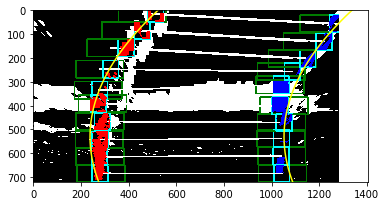

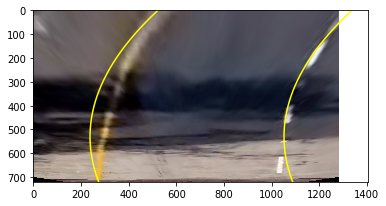

In [177]:


#part 4. find the lanes from the binary images
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image

#moved this here, maybe change place
ploty = np.linspace(0, images[0].shape[0]-1, images[0].shape[0] )
print(np.shape(ploty))
# Define conversions in x and y from pixels space to meters
ym_per_pix = 40/720. # meters per pixel in y dimension
xm_per_pix = 3.7/720. # meters per pixel in x dimension



def laneFinder(image):
    global xm_per_pix
    
    binary_warped = image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    lane_width=rightx_base-leftx_base
    
    xm_per_pix = (3.7/lane_width + xm_per_pix)/2 #should be more exact?
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 10
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    left_sum=0
    right_sum=0
    
    y_diff=0
    # Step through the windows one by one
    diffLOld=0
    diffROld=0
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        #win_y_low = binary_warped.shape[0] - ((window+1)*window_height)
        #win_y_high = binary_warped.shape[0] - (window*window_height)
        win_y_lowL = np.int(binary_warped.shape[0] - ((window+1)*window_height+y_diff))
        win_y_highL = np.int(binary_warped.shape[0] - (window*window_height+y_diff))
        win_y_low = np.int(binary_warped.shape[0] - ((window+1)*window_height-y_diff))
        win_y_high = np.int(binary_warped.shape[0] - (window*window_height-y_diff))
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #print(f"{win_xleft_low},{win_y_lowL},{win_xleft_high},{win_y_highL}")
        cv2.rectangle(out_img,(win_xleft_low,win_y_lowL),(win_xleft_high,win_y_highL),(0,123,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,123,0), 5) 
        pt1=((win_xleft_high+win_xleft_low)//2,(win_y_highL+win_y_lowL)//2)
        pt2=((win_xright_high+win_xright_low)//2,(win_y_high+win_y_low)//2)
        cv2.line(out_img,pt1,pt2,(255,255,255),5)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_lowL) & (nonzeroy < win_y_highL) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        #good_left_inds = ((nonzeroy >= win_y_lowL) & (nonzeroy < win_y_highL) & 
        #(nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        #good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        #(nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        #print(nonzerox[good_right_inds]-win_xright_low)
        #print(nonzerox[good_left_inds]-win_xleft_low)

 
        if len(good_left_inds) > minpix or len(good_right_inds) > minpix:
            
            nonzerox_left=nonzerox[good_right_inds]-win_xright_low
            nonzerox_right=nonzerox[good_left_inds]-win_xleft_low+abs(y_diff)
            nonzerox_tmp=np.concatenate((nonzerox_left,nonzerox_right))
            bins=np.bincount(nonzerox_tmp)
            best_index=np.argmax(bins)-margin
            mean_index=np.mean(nonzerox_tmp)-margin
            right_diff = left_diff = (best_index+mean_index)//2
            y_diff=np.int((right_diff+left_diff+y_diff)//8)
            diffROld=right_diff*.5+diffROld*0.5
            diffLOld=left_diff*.5+diffLOld*0.5
        leftx_current +=  np.int(diffLOld)#np.int(diffs)
        rightx_current += np.int(diffROld) #np.int(diffs)
        
        win_xleft_low = leftx_current - margin//3
        win_xleft_high = leftx_current + margin//3
        win_xright_low = rightx_current - margin//3
        win_xright_high = rightx_current + margin//3
        
        good_left_inds = ((nonzeroy >= win_y_lowL) & (nonzeroy < win_y_highL) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            
        cv2.rectangle(out_img,(win_xleft_low,win_y_lowL),(win_xleft_high,win_y_highL),(0,255,255), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,255), 5) 
        pt1=((win_xleft_high+win_xleft_low)//2,(win_y_highL+win_y_lowL)//2)
        pt2=((win_xright_high+win_xright_low)//2,(win_y_high+win_y_low)//2)
        cv2.line(out_img,pt1,pt2,(255,255,255),5)
      
            
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)   
   
                
    
    


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit new polynomials to x,y in world space
    
    #ploty = np.linspace(0, 719, num=720)
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    
    
    tmp=(left_fit[0]+right_fit[0])/2
    left_fit[0]=tmp
    right_fit[0]=tmp
    
    tmp=(left_fit[1]+right_fit[1])/2
    left_fit[1]=tmp
    right_fit[1]=tmp
    
    tmp=(left_fit_cr[0]+right_fit_cr[0])/2
    left_fit_cr[0]=tmp
    right_fit_cr[0]=tmp
    
    tmp=(left_fit_cr[1]+right_fit_cr[1])/2
    left_fit_cr[1]=tmp
    right_fit_cr[1]=tmp
    return left_fit, right_fit, left_fit_cr ,right_fit_cr ,out_img

plt.imshow(out_img)
imageIndex=6#np.random.randint(len(images))
binary_warped=getBinaryWarp(images[imageIndex],9,30,230,30,230,30,150,0.7,1.3,80,255)
left_fit, right_fit,left_fit_cr ,right_fit_cr , out_img = laneFinder(binary_warped)

print(left_fit)
print(right_fit)

#both lines should be parrallel from above,
#also, diff in [2] should be about the same for all images (dist between lanes),
#so can use some sane filter using this.
#tmp=(left_fit[0]+right_fit[0])/2
#left_fit[0]=tmp
#right_fit[0]=tmp
#tmp=(left_fit[1]+right_fit[1])/2
#left_fit[1]=tmp
#right_fit[1]=tmp
plt.imshow(out_img)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
print(np.shape(ploty))
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]




plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)
plt.show()
plt.imshow(corners_unwarp_road(images[imageIndex]))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

6

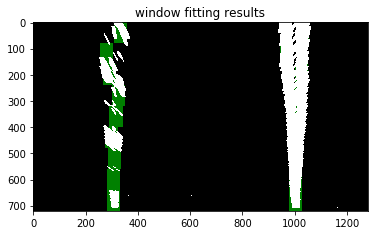

In [7]:

#import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Read in a thresholded image
warped = getBinaryWarp(images[imageIndex],9,30,230,30,230,30,150,0.7,1.3,110,255)
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [28]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.min(ploty)
left_curverad = (abs(1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = (abs(1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

# Example values: 1926.74 1908.48


yo = ym_per_pix#(image.shape[1]-1) * ym_per_pix

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

left_curverad = ((1 + (2*left_fit_cr[0]*yo + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*yo + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

2980.91389806 2057.82090787
602.336546303 m 371.75380621 m
602.326665822 m 371.74254263 m


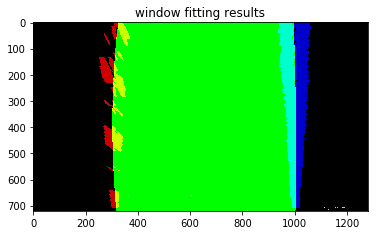

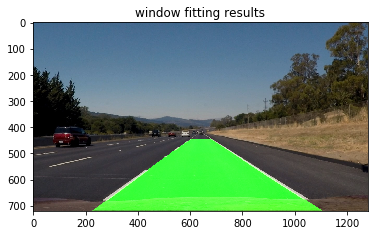

In [9]:
#calculate and draw when unwarped
filled_area=np.zeros_like(image).astype(np.uint8)
fitx_both=np.concatenate((np.transpose([left_fitx,ploty]),np.transpose([right_fitx[::-1],ploty[::-1]])))
cv2.fillPoly(filled_area,np.int_([fitx_both]),(0,255,0))
out_img2= cv2.addWeighted(filled_area,1,out_img,0.8,0)
plt.imshow(out_img2)
plt.title('window fitting results')
plt.show()
filled_area_unwarp = corners_unwarp_road(filled_area,True)
out_img2= cv2.addWeighted(filled_area_unwarp,1,images[imageIndex],0.8,0)
plt.imshow(out_img2)
plt.title('window fitting results')
plt.show()

In [44]:
def addFilledArea(image,left_fitx,right_fitx,ploty):
 
    filled_area=np.zeros_like(image).astype(np.uint8)
    fitx_both=np.concatenate((np.transpose([left_fitx,ploty]),np.transpose([right_fitx[::-1],ploty[::-1]])))
    cv2.fillPoly(filled_area,np.int_([fitx_both]),(0,255,0))
    
    filled_area_unwarp = corners_unwarp_road(filled_area,True)
   
    return cv2.addWeighted(filled_area_unwarp,1,image,0.8,0)

def addText(image,center_dist,left_curverad,right_curverad):
    cv2.putText(image, f"Curve Left: {left_curverad}",(50,100),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
    cv2.putText(image, f"Curve Right: {right_curverad}",(50,150),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
    cv2.putText(image, f"Center Distance: {center_dist}",(50,200),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
    return image

256,648,456,720
259,575,459,647
260,504,460,576
262,432,462,504
252,366,452,438
227,299,427,371
202,224,402,296
162,159,362,231
124,83,324,155
78,16,278,88


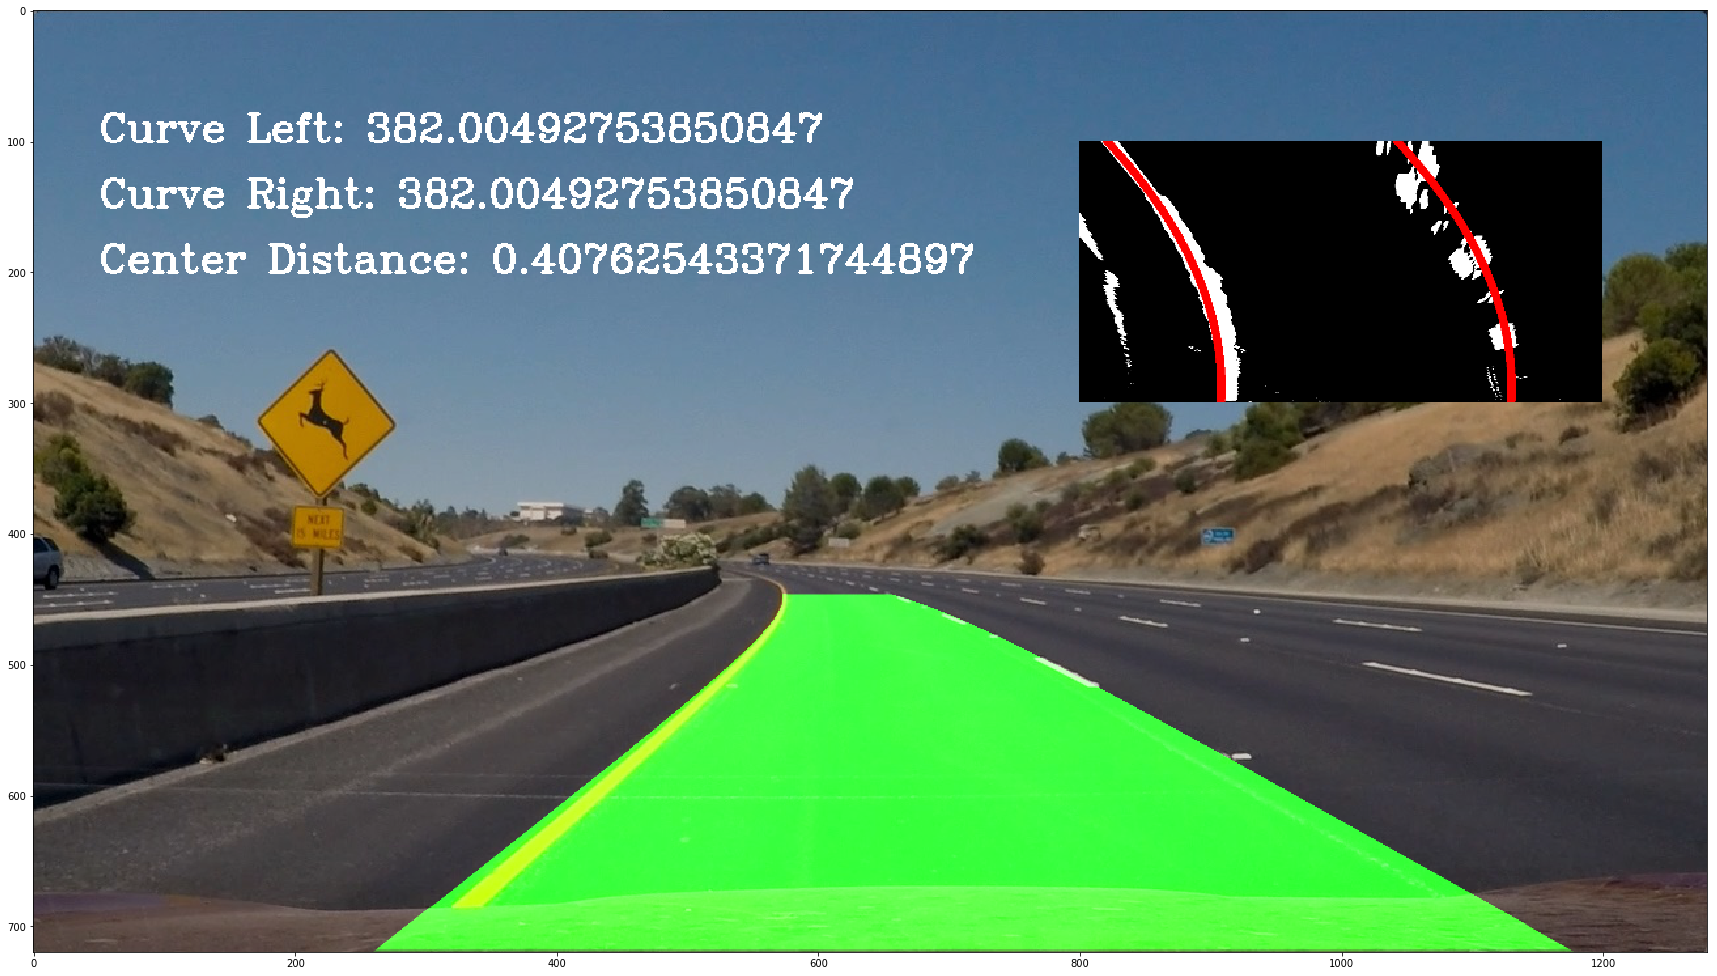

In [176]:
## Main pipline
# There's probably better ways so we can use variables as 
# arguments instead of globals
def process_image(input_image):
    image = undistort(input_image, objpoints, imgpoints)

    image = getBinaryWarp(image,9,30,230,30,230,30,150,0.7,1.3,110,255)
    binary_image=image.copy()
    left_fit, right_fit,left_fit_cr ,right_fit_cr, image = laneFinder(image) 

    
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    result_image = addFilledArea(input_image,left_fitx,right_fitx,ploty)
    

    y_eval = np.max(ploty)#
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1] )**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    center_dist=(left_fitx[-1]+right_fitx[-1])*xm_per_pix/2 - (out_img.shape[1]*xm_per_pix)/2 

    
    #add binarry in corner
    #https://stackoverflow.com/questions/14063070/overlay-a-smaller-image-on-a-larger-image-python-opencv
    x_offset=800
    y_offset=100
    

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    binary_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)*255 
    pts=np.int32(np.transpose(np.array([left_fitx,ploty])))
    pts2=np.int32(np.transpose(np.array([right_fitx,ploty])))
    binary_image=cv2.polylines(binary_image,[pts],False,(255,0,0),20)
    binary_image=cv2.polylines(binary_image,[pts2],False,(255,0,0),20)
    
    binary_image = cv2.resize(binary_image, (400,200))
    
    result_image = addText(result_image,center_dist,left_curverad,right_curverad)
    result_image[y_offset:y_offset+200, x_offset:x_offset+400] = binary_image
    
    
    return result_image

images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob('test_images/*.jpg')]
imageIndex=np.random.randint(len(images)-1)

plt.figure(figsize = (30,30)) 
plt.imshow(process_image(images[imageIndex]))



In [12]:
np.int32(np.transpose(np.array([ploty,left_fitx])))

array([[  0, 325],
       [  1, 325],
       [  2, 325],
       ..., 
       [717, 319],
       [718, 319],
       [719, 319]], dtype=int32)

In [175]:
#main part
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'test_videos_output/project_video.mp4'

video_input = VideoFileClip("project_video.mp4").subclip(0,5)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
video = video_input.fl_image(process_image) #NOTE: this function expects color images!!
%time video.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video))

320,648,520,720
311,581,511,653
311,503,511,575
320,428,520,500
320,362,520,434
320,289,520,361
344,204,544,276
368,132,568,204
392,60,592,132
370,16,570,88
[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4



  1%|          | 1/150 [00:01<03:18,  1.34s/it]

320,648,520,720
311,581,511,653
311,503,511,575
320,428,520,500
320,362,520,434
320,289,520,361
344,204,544,276
368,132,568,204
392,60,592,132
370,16,570,88



  1%|▏         | 2/150 [00:02<03:15,  1.32s/it]

302,648,502,720
297,579,497,651
301,501,501,573
336,415,536,487
336,367,536,439
326,295,526,367
348,204,548,276
370,132,570,204
392,60,592,132
445,-22,645,50



  2%|▏         | 3/150 [00:03<03:09,  1.29s/it]

294,648,494,720
293,577,493,649
299,501,499,573
307,429,507,501
302,365,502,437
309,284,509,356
340,202,540,274
371,130,571,202
402,58,602,130
406,4,606,76



  3%|▎         | 4/150 [00:05<03:08,  1.29s/it]

296,648,496,720
294,577,494,649
299,501,499,573
306,430,506,502
301,365,501,437
308,284,508,356
336,204,536,276
364,132,564,204
357,82,557,154
350,10,550,82



  3%|▎         | 5/150 [00:06<03:09,  1.30s/it]

290,648,490,720
289,577,489,649
295,501,495,573
299,431,499,503
291,366,491,438
301,282,501,354
330,204,530,276
359,132,559,204
347,85,547,157
335,13,535,85



  4%|▍         | 6/150 [00:07<03:04,  1.28s/it]

317,648,517,720
307,581,507,653
310,501,510,573
318,429,518,501
318,363,518,435
329,283,529,355
349,208,549,280
369,136,569,208
339,92,539,164
309,20,509,92



  5%|▍         | 7/150 [00:09<03:04,  1.29s/it]

336,648,536,720
329,580,529,652
330,502,530,574
348,423,548,495
356,360,556,432
350,294,550,366
376,202,576,274
402,130,602,202
428,58,628,130
418,10,618,82



  5%|▌         | 8/150 [00:10<03:02,  1.29s/it]

344,648,544,720
331,583,531,655
330,503,530,575
337,428,537,500
342,359,542,431
342,290,542,362
373,201,573,273
404,129,604,201
435,57,635,129
456,-4,656,68



  6%|▌         | 9/150 [00:11<03:00,  1.28s/it]

344,648,544,720
324,586,524,658
324,500,524,572
346,421,546,493
359,358,559,430
359,292,559,364
396,198,596,270
433,126,633,198
470,54,670,126
480,2,680,74



  7%|▋         | 10/150 [00:12<02:57,  1.27s/it]

331,648,531,720
326,579,526,651
333,500,533,572
344,428,544,500
349,360,549,432
343,293,543,365
364,205,564,277
385,133,585,205
406,61,606,133
419,-2,619,70



  7%|▋         | 11/150 [00:14<02:56,  1.27s/it]

321,648,521,720
317,579,517,651
325,499,525,571
337,428,537,500
342,360,542,432
334,294,534,366
352,206,552,278
370,134,570,206
388,62,588,134
382,7,582,79



  8%|▊         | 12/150 [00:15<02:55,  1.27s/it]

317,648,517,720
314,578,514,650
323,499,523,571
336,428,536,500
343,359,543,431
335,294,535,366
369,198,569,270
403,126,603,198
437,54,637,126
471,-18,671,54



  9%|▊         | 13/150 [00:16<02:51,  1.25s/it]

298,648,498,720
297,577,497,649
309,498,509,570
320,429,520,501
325,360,525,432
316,294,516,366
343,201,543,273
370,129,570,201
397,57,597,129
384,12,584,84



  9%|▉         | 14/150 [00:17<02:49,  1.25s/it]

292,648,492,720
293,576,493,648
305,498,505,570
314,430,514,502
325,357,525,429
319,294,519,366
338,206,538,278
357,134,557,206
376,62,576,134
344,20,544,92



 10%|█         | 15/150 [00:18<02:46,  1.23s/it]

283,648,483,720
289,573,489,645
299,500,499,572
306,431,506,503
318,356,518,428
312,294,512,366
328,207,528,279
344,135,544,207
360,63,560,135
333,17,533,89



 11%|█         | 16/150 [00:20<02:43,  1.22s/it]

283,648,483,720
286,575,486,647
300,498,500,570
308,431,508,503
319,357,519,429
311,295,511,367
329,206,529,278
347,134,547,206
365,62,565,134
339,17,539,89



 11%|█▏        | 17/150 [00:21<02:40,  1.21s/it]

336,648,536,720
329,580,529,652
332,501,532,573
354,422,554,494
383,350,583,422
381,296,581,368
392,211,592,283
437,124,637,196
482,52,682,124
527,-20,727,52



 12%|█▏        | 18/150 [00:22<02:38,  1.20s/it]

333,648,533,720
325,581,525,653
327,502,527,574
346,423,546,495
366,354,566,426
352,300,552,372
352,214,552,286
352,142,552,214
352,70,552,142
352,-2,552,70



 13%|█▎        | 19/150 [00:23<02:37,  1.20s/it]

270,648,470,720
272,575,472,647
276,503,476,575
276,434,476,506
277,360,477,432
277,289,477,361
274,218,474,290
271,146,471,218
244,86,444,158
217,14,417,86



 13%|█▎        | 20/150 [00:25<02:41,  1.24s/it]

331,648,531,720
325,579,525,651
326,503,526,575
344,423,544,495
361,355,561,427
340,303,540,375
339,214,539,286
338,142,538,214
337,70,537,142
357,-11,557,61



 14%|█▍        | 21/150 [00:26<02:37,  1.22s/it]

322,648,522,720
318,579,518,651
319,503,519,575
340,422,540,494
359,355,559,427
372,286,572,358
370,221,570,293
368,149,568,221
327,93,527,165
300,6,500,78



 15%|█▍        | 22/150 [00:27<02:36,  1.22s/it]

317,648,517,720
314,578,514,650
316,502,516,574
336,422,536,494
355,355,555,427
367,286,567,358
372,216,572,288
377,144,577,216
342,91,542,163
307,19,507,91



 15%|█▌        | 23/150 [00:28<02:34,  1.22s/it]

319,648,519,720
315,579,515,651
317,503,517,575
339,422,539,494
361,353,561,425
358,295,558,367
358,217,558,289
358,145,558,217
358,73,558,145
339,10,539,82



 16%|█▌        | 24/150 [00:29<02:32,  1.21s/it]

319,648,519,720
315,578,515,650
317,502,517,574
339,421,539,493
330,369,530,441
314,296,514,368
329,205,529,277
344,133,544,205
359,61,559,133
339,13,539,85



 17%|█▋        | 25/150 [00:31<02:35,  1.24s/it]

312,648,512,720
310,578,510,650
313,502,513,574
333,423,533,495
319,372,519,444
303,294,503,366
322,203,522,275
341,131,541,203
360,59,560,131
379,-13,579,59



 17%|█▋        | 26/150 [00:32<02:35,  1.25s/it]

318,648,518,720
307,582,507,654
307,502,507,574
319,426,519,498
324,360,524,432
331,286,531,358
352,207,552,279
373,135,573,207
394,63,594,135
406,-1,606,71



 18%|█▊        | 27/150 [00:33<02:32,  1.24s/it]

338,648,538,720
323,584,523,656
314,506,514,578
326,424,526,496
314,369,514,441
307,290,507,362
334,201,534,273
361,129,561,201
388,57,588,129
398,0,598,72



 19%|█▊        | 28/150 [00:34<02:29,  1.22s/it]

389,648,589,720
371,585,571,657
356,509,556,581
366,424,566,496
384,353,584,425
393,287,593,359
414,208,614,280
435,136,635,208
456,64,656,136
422,22,622,94



 19%|█▉        | 29/150 [00:36<02:27,  1.22s/it]

379,648,579,720
360,586,560,658
349,506,549,578
353,428,553,500
368,353,568,425
383,284,583,356
420,201,620,273
457,129,657,201
494,57,694,129
531,-15,731,57



 20%|██        | 30/150 [00:37<02:31,  1.27s/it]

307,648,507,720
295,583,495,655
299,500,499,572
310,427,510,499
316,359,516,431
338,279,538,351
387,196,587,268
436,124,636,196
485,52,685,124
534,-20,734,52



 21%|██        | 31/150 [00:38<02:31,  1.27s/it]

346,648,546,720
320,589,520,661
313,503,513,575
328,423,528,495
345,354,545,426
373,278,573,350
419,199,619,271
465,127,665,199
530,49,730,121
574,-8,774,64



 21%|██▏       | 32/150 [00:39<02:29,  1.27s/it]

331,648,531,720
316,584,516,656
317,501,517,573
330,426,530,498
338,359,538,431
364,277,564,349
414,196,614,268
464,124,664,196
483,73,683,145
502,1,702,73



 22%|██▏       | 33/150 [00:41<02:26,  1.25s/it]

337,648,537,720
320,585,520,657
320,502,520,574
331,426,531,498
340,358,540,430
369,276,569,348
416,199,616,271
403,161,603,233
423,61,623,133
474,-21,674,51



 23%|██▎       | 34/150 [00:42<02:23,  1.24s/it]

377,648,577,720
356,587,556,659
343,507,543,579
345,428,545,500
354,356,554,428
372,281,572,353
412,200,612,272
452,128,652,200
490,61,690,133
520,-7,720,65



 23%|██▎       | 35/150 [00:43<02:20,  1.23s/it]

378,648,578,720
358,587,558,659
344,508,544,580
345,428,545,500
324,371,524,443
334,279,534,351
374,198,574,270
387,145,587,217
442,48,642,120
504,-20,704,52



 24%|██▍       | 36/150 [00:44<02:20,  1.23s/it]

314,648,514,720
302,583,502,655
302,503,502,575
315,426,515,498
318,361,518,433
346,275,546,347
411,189,611,261
476,117,676,189
476,86,676,158
485,-3,685,69



 25%|██▍       | 37/150 [00:46<02:19,  1.23s/it]

346,648,546,720
329,585,529,657
321,506,521,578
334,424,534,496
343,358,543,430
374,275,574,347
435,192,635,264
496,120,696,192
557,48,757,120
564,9,764,81



 25%|██▌       | 38/150 [00:47<02:20,  1.25s/it]

336,648,536,720
321,584,521,656
314,505,514,577
327,424,527,496
342,355,542,427
367,279,567,351
360,226,560,298
353,154,553,226
388,54,588,126
455,-27,655,45



 26%|██▌       | 39/150 [00:48<02:16,  1.23s/it]

337,648,537,720
323,584,523,656
317,505,517,577
323,428,523,500
336,355,536,427
364,277,564,349
368,220,568,292
372,148,572,220
400,60,600,132
451,-20,651,52



 27%|██▋       | 40/150 [00:49<02:13,  1.21s/it]

329,648,529,720
317,582,517,654
313,504,513,576
325,425,525,497
339,355,539,427
374,274,574,346
370,226,570,298
366,154,566,226
390,60,590,132
441,-21,641,51



 27%|██▋       | 41/150 [00:50<02:11,  1.21s/it]

325,648,525,720
312,583,512,655
308,504,508,576
315,428,515,500
328,355,528,427
364,273,564,345
421,195,621,267
478,123,678,195
470,88,670,160
462,16,662,88



 28%|██▊       | 42/150 [00:52<02:11,  1.22s/it]

303,648,503,720
294,581,494,653
297,501,497,573
308,427,508,499
322,356,522,428
359,273,559,345
412,197,612,269
465,125,665,197
496,68,696,140
527,-4,727,68



 29%|██▊       | 43/150 [00:53<02:12,  1.24s/it]

310,648,510,720
301,581,501,653
303,502,503,574
313,427,513,499
325,356,525,428
359,274,559,346
329,238,529,310
329,140,529,212
346,63,546,135
396,-21,596,51



 29%|██▉       | 44/150 [00:54<02:10,  1.23s/it]

268,648,468,720
268,576,468,648
275,501,475,573
274,435,474,507
288,353,488,425
323,274,523,346
315,228,515,300
307,156,507,228
309,71,509,143
311,-1,511,71



 30%|███       | 45/150 [00:55<02:10,  1.25s/it]

297,648,497,720
290,580,490,652
294,501,494,573
295,433,495,505
306,355,506,427
349,269,549,341
388,205,588,277
427,133,627,205
403,93,603,165
379,21,579,93



 31%|███       | 46/150 [00:57<02:09,  1.24s/it]

287,648,487,720
281,580,481,652
286,501,486,573
292,430,492,502
304,355,504,427
346,270,546,342
388,203,588,275
430,131,630,203
403,95,603,167
376,23,576,95



 31%|███▏      | 47/150 [00:58<02:06,  1.23s/it]

299,648,499,720
291,581,491,653
294,501,494,573
300,430,500,502
319,352,519,424
359,272,559,344
400,204,600,276
441,132,641,204
460,71,660,143
442,14,642,86



 32%|███▏      | 48/150 [00:59<02:04,  1.22s/it]

288,648,488,720
280,580,480,652
285,500,485,572
290,431,490,503
309,352,509,424
350,272,550,344
390,205,590,277
430,133,630,205
470,61,670,133
449,20,649,92



 33%|███▎      | 49/150 [01:00<02:02,  1.21s/it]

258,648,458,720
259,576,459,648
271,498,471,570
277,432,477,504
302,349,502,421
344,272,544,344
385,204,585,276
426,132,626,204
467,60,667,132
447,20,647,92



 33%|███▎      | 50/150 [01:01<02:00,  1.21s/it]

270,648,470,720
266,578,466,650
271,501,471,573
271,434,471,506
292,350,492,422
329,274,529,346
387,195,587,267
445,123,645,195
503,51,703,123
561,-21,761,51



 34%|███▍      | 51/150 [01:03<01:59,  1.21s/it]

266,648,466,720
260,580,460,652
260,503,460,575
260,433,460,505
285,348,485,420
324,274,524,346
378,197,578,269
432,125,632,197
486,53,686,125
487,11,687,83



 35%|███▍      | 52/150 [01:04<02:00,  1.23s/it]

260,648,460,720
258,577,458,649
258,504,458,576
257,433,457,505
281,348,481,420
317,275,517,347
368,198,568,270
419,126,619,198
413,86,613,158
378,18,578,90



 35%|███▌      | 53/150 [01:05<01:59,  1.23s/it]

254,648,454,720
254,577,454,649
258,502,458,574
258,433,458,505
280,349,480,421
314,276,514,348
365,198,565,270
416,126,616,198
403,90,603,162
363,20,563,92



 36%|███▌      | 54/150 [01:06<01:58,  1.23s/it]

251,648,451,720
251,577,451,649
253,503,453,575
253,433,453,505
277,348,477,420
316,273,516,345
369,198,569,270
422,126,622,198
475,54,675,126
528,-18,728,54



 37%|███▋      | 55/150 [01:08<01:59,  1.25s/it]

275,648,475,720
267,581,467,653
273,500,473,572
277,431,477,503
302,349,502,421
343,273,543,345
393,200,593,272
443,128,643,200
493,56,693,128
543,-16,743,56



 37%|███▋      | 56/150 [01:09<01:59,  1.27s/it]

255,648,455,720
254,577,454,649
260,501,460,573
263,432,463,504
287,349,487,421
323,275,523,347
313,229,513,301
275,163,475,235
237,91,437,163
236,-6,436,66



 38%|███▊      | 57/150 [01:10<01:57,  1.26s/it]

322,648,522,720
311,582,511,654
309,503,509,575
311,431,511,503
339,347,539,419
398,264,598,336
453,200,653,272
508,128,708,200
563,56,763,128
618,-16,818,56



 39%|███▊      | 58/150 [01:12<01:55,  1.25s/it]

261,648,461,720
257,578,457,650
262,501,462,573
268,430,468,502
298,347,498,419
347,270,547,342
396,198,596,270
445,126,645,198
494,54,694,126
543,-18,743,54



 39%|███▉      | 59/150 [01:13<01:53,  1.24s/it]

253,648,453,720
255,575,455,647
255,505,455,577
264,428,464,500
294,347,494,419
341,271,541,343
388,199,588,271
435,127,635,199
482,55,682,127
529,-17,729,55



 40%|████      | 60/150 [01:14<01:52,  1.25s/it]

269,648,469,720
264,579,464,651
270,501,470,573
283,427,483,499
314,347,514,419
361,271,561,343
408,199,608,271
455,127,655,199
502,55,702,127
549,-17,749,55



 41%|████      | 61/150 [01:15<01:50,  1.25s/it]

258,648,458,720
252,580,452,652
251,504,451,576
256,429,456,501
298,340,498,412
340,275,540,347
382,203,582,275
424,131,624,203
466,59,666,131
508,-13,708,59



 41%|████▏     | 62/150 [01:16<01:49,  1.24s/it]

286,648,486,720
272,584,472,656
271,502,471,574
278,428,478,500
308,347,508,419
359,269,559,341
410,197,610,269
461,125,661,197
512,53,712,125
563,-19,763,53



 42%|████▏     | 63/150 [01:18<01:47,  1.24s/it]

251,648,451,720
246,579,446,651
244,505,444,577
250,429,450,501
291,341,491,413
331,276,531,348
371,204,571,276
363,157,563,229
355,85,555,157
347,13,547,85



 43%|████▎     | 64/150 [01:19<01:45,  1.23s/it]

389,648,589,720
382,580,582,652
369,510,569,582
368,430,568,502
381,353,581,425
428,267,628,339
407,236,607,308
358,166,558,238
309,94,509,166
260,22,460,94



 43%|████▎     | 65/150 [01:20<01:44,  1.23s/it]

309,648,509,720
295,584,495,656
294,502,494,574
299,429,499,501
339,341,539,413
386,272,586,344
433,200,633,272
416,163,616,235
399,91,599,163
382,19,582,91



 44%|████▍     | 66/150 [01:21<01:43,  1.23s/it]

377,648,577,720
369,580,569,652
357,509,557,581
355,431,555,503
373,350,573,422
424,266,624,338
475,194,675,266
526,122,726,194
577,50,777,122
628,-22,828,50



 45%|████▍     | 67/150 [01:23<01:42,  1.23s/it]

364,648,564,720
353,582,553,654
344,507,544,579
346,430,546,502
367,350,567,422
420,266,620,338
473,194,673,266
489,147,689,219
505,75,705,147
521,3,721,75



 45%|████▌     | 68/150 [01:24<01:41,  1.24s/it]

357,648,557,720
344,583,544,655
336,506,536,578
337,430,537,502
371,343,571,415
441,260,641,332
511,188,711,260
512,158,712,230
513,86,713,158
480,19,680,91



 46%|████▌     | 69/150 [01:25<01:40,  1.24s/it]

352,648,552,720
348,578,548,650
345,505,545,577
344,432,544,504
375,344,575,416
439,262,639,334
503,190,703,262
505,156,705,228
507,84,707,156
475,19,675,91



 47%|████▋     | 70/150 [01:26<01:39,  1.24s/it]

343,648,543,720
334,581,534,653
331,505,531,577
335,429,535,501
369,344,569,416
439,260,639,332
509,188,709,260
509,158,709,230
509,86,709,158
468,23,668,95



 47%|████▋     | 71/150 [01:28<01:38,  1.25s/it]

340,648,540,720
329,582,529,654
326,504,526,576
331,429,531,501
368,343,568,415
441,259,641,331
514,187,714,259
509,162,709,234
504,90,704,162
458,24,658,96



 48%|████▊     | 72/150 [01:29<01:37,  1.25s/it]

328,648,528,720
319,581,519,653
318,504,518,576
327,427,527,499
364,344,564,416
437,259,637,331
510,187,710,259
583,115,783,187
656,43,856,115
729,-29,929,43



 49%|████▊     | 73/150 [01:30<01:35,  1.24s/it]

314,648,514,720
307,580,507,652
305,504,505,576
316,426,516,498
355,343,555,415
427,260,627,332
499,188,699,260
571,116,771,188
643,44,843,116
715,-28,915,44



 49%|████▉     | 74/150 [01:31<01:34,  1.24s/it]

305,648,505,720
300,579,500,651
300,504,500,576
312,426,512,498
352,342,552,414
428,258,628,330
504,186,704,258
580,114,780,186
656,42,856,114
732,-30,932,42



 50%|█████     | 75/150 [01:33<01:33,  1.25s/it]

300,648,500,720
296,578,496,650
296,504,496,576
308,426,508,498
349,342,549,414
426,258,626,330
503,186,703,258
580,114,780,186
657,42,857,114
734,-30,934,42



 51%|█████     | 76/150 [01:34<01:32,  1.26s/it]

294,648,494,720
291,578,491,650
296,501,496,573
316,423,516,495
365,340,565,412
446,258,646,330
527,186,727,258
608,114,808,186
689,42,889,114
770,-30,970,42



 51%|█████▏    | 77/150 [01:35<01:32,  1.27s/it]

286,648,486,720
283,578,483,650
288,501,488,573
307,424,507,496
355,340,555,412
437,257,637,329
519,185,719,257
601,113,801,185
683,41,883,113
765,-31,965,41



 52%|█████▏    | 78/150 [01:37<01:33,  1.30s/it]

336,648,536,720
328,581,528,653
325,505,525,577
337,426,537,498
375,344,575,416
448,259,648,331
545,182,745,254
642,110,842,182
739,38,939,110
836,-34,1036,38



 53%|█████▎    | 79/150 [01:38<01:32,  1.31s/it]

273,648,473,720
267,579,467,651
261,506,461,578
272,425,472,497
319,339,519,411
366,267,566,339
413,195,613,267
390,165,590,237
367,93,567,165
344,21,544,93



 53%|█████▎    | 80/150 [01:39<01:31,  1.30s/it]

262,648,462,720
257,579,457,651
257,503,457,575
275,423,475,495
326,338,526,410
377,266,577,338
428,194,628,266
479,122,679,194
530,50,730,122
581,-22,781,50



 54%|█████▍    | 81/150 [01:40<01:29,  1.29s/it]

307,648,507,720
295,583,495,655
291,504,491,576
299,427,499,499
350,336,550,408
401,264,601,336
452,192,652,264
429,166,629,238
406,94,606,166
383,22,583,94



 55%|█████▍    | 82/150 [01:42<01:28,  1.30s/it]

295,648,495,720
283,582,483,654
280,504,480,576
290,427,490,499
341,337,541,409
392,265,592,337
443,193,643,265
494,121,694,193
545,49,745,121
596,-23,796,49



 55%|█████▌    | 83/150 [01:43<01:28,  1.32s/it]

283,648,483,720
273,582,473,654
273,503,473,575
284,427,484,499
336,337,536,409
388,265,588,337
440,193,640,265
492,121,692,193
544,49,744,121
596,-23,796,49



 56%|█████▌    | 84/150 [01:45<01:28,  1.34s/it]

302,648,502,720
290,583,490,655
287,504,487,576
294,428,494,500
341,338,541,410
423,256,623,328
505,184,705,256
587,112,787,184
669,40,869,112
751,-32,951,40



 57%|█████▋    | 85/150 [01:46<01:28,  1.36s/it]

296,648,496,720
285,582,485,654
285,503,485,575
294,428,494,500
344,337,544,409
427,257,627,329
510,185,710,257
593,113,793,185
676,41,876,113
759,-31,959,41



 57%|█████▋    | 86/150 [01:47<01:26,  1.35s/it]

336,648,536,720
326,581,526,653
321,505,521,577
322,430,522,502
358,342,558,414
432,258,632,330
532,181,732,253
632,109,832,181
732,37,932,109
832,-35,1032,37



 58%|█████▊    | 87/150 [01:48<01:22,  1.32s/it]

328,648,528,720
321,580,521,652
316,506,516,578
320,429,520,501
361,341,561,413
437,258,637,330
513,186,713,258
589,114,789,186
665,42,865,114
741,-30,941,42



 59%|█████▊    | 88/150 [01:50<01:20,  1.29s/it]

319,648,519,720
313,579,513,651
309,506,509,578
318,427,518,499
362,340,562,412
442,257,642,329
522,185,722,257
602,113,802,185
682,41,882,113
762,-31,962,41



 59%|█████▉    | 89/150 [01:51<01:18,  1.29s/it]

307,648,507,720
303,578,503,650
299,506,499,578
316,423,516,495
371,336,571,408
457,256,657,328
543,184,743,256
629,112,829,184
715,40,915,112
801,-32,1001,40



 60%|██████    | 90/150 [01:53<01:24,  1.42s/it]

396,648,596,720
393,578,593,650
391,505,591,577
364,446,564,518
370,352,570,424
419,264,619,336
411,230,611,302
403,158,603,230
409,69,609,141
426,-7,626,65



 61%|██████    | 91/150 [01:54<01:24,  1.44s/it]

396,648,596,720
394,577,594,649
386,508,586,580
361,443,561,515
369,351,569,423
423,262,623,334
409,234,609,306
395,162,595,234
390,74,590,146
397,-4,597,68



 61%|██████▏   | 92/150 [01:56<01:24,  1.45s/it]

387,648,587,720
385,577,585,649
367,513,567,585
343,441,543,513
358,348,558,420
416,261,616,333
400,236,600,308
384,164,584,236
377,74,577,146
380,-3,580,69



 62%|██████▏   | 93/150 [01:57<01:22,  1.45s/it]

381,648,581,720
375,579,575,651
364,509,564,581
342,441,542,513
353,350,553,422
409,262,609,334
391,236,591,308
373,164,573,236
364,75,564,147
381,-10,581,62



 63%|██████▎   | 94/150 [01:58<01:18,  1.40s/it]

361,648,561,720
346,584,546,656
330,510,530,582
319,435,519,507
348,344,548,416
417,259,617,331
486,187,686,259
555,115,755,187
624,43,824,115
693,-29,893,43



 63%|██████▎   | 95/150 [02:00<01:14,  1.36s/it]

366,648,566,720
356,582,556,654
340,511,540,583
322,438,522,510
348,343,548,415
416,259,616,331
484,187,684,259
552,115,752,187
620,43,820,115
688,-29,888,43



 64%|██████▍   | 96/150 [02:01<01:12,  1.35s/it]

362,648,562,720
322,596,522,668
304,506,504,578
308,426,508,498
288,371,488,443
295,281,495,353
331,199,531,271
367,127,567,199
403,55,603,127
439,-17,639,55



 65%|██████▍   | 97/150 [02:02<01:09,  1.31s/it]

327,648,527,720
310,585,510,657
310,501,510,573
323,426,523,498
365,342,565,414
351,304,551,376
357,211,557,283
363,139,563,211
369,67,569,139
375,-5,575,67



 65%|██████▌   | 98/150 [02:03<01:07,  1.29s/it]

330,648,530,720
318,583,518,655
314,504,514,576
330,423,530,495
385,336,585,408
449,267,649,339
490,209,690,281
495,151,695,223
508,68,708,140
470,22,670,94



 66%|██████▌   | 99/150 [02:05<01:05,  1.29s/it]

315,648,515,720
309,580,509,652
297,509,497,581
323,417,523,489
386,334,586,406
447,270,647,342
508,198,708,270
506,159,706,231
499,77,699,149
454,22,654,94



 67%|██████▋   | 100/150 [02:06<01:03,  1.28s/it]

404,648,604,720
393,582,593,654
362,518,562,590
365,425,565,497
400,343,600,415
386,303,586,375
372,231,572,303
332,163,532,235
331,66,531,138
367,-19,567,53



 67%|██████▋   | 101/150 [02:07<01:02,  1.28s/it]

394,648,594,720
382,583,582,655
343,522,543,594
347,422,547,494
390,338,590,410
382,301,582,373
374,229,574,301
324,169,524,241
303,74,503,146
329,-18,529,54



 68%|██████▊   | 102/150 [02:09<01:01,  1.28s/it]

385,648,585,720
371,583,571,655
332,521,532,593
344,419,544,491
385,341,585,413
446,266,646,338
523,190,723,262
600,118,800,190
593,92,793,164
586,20,786,92



 69%|██████▊   | 103/150 [02:10<00:59,  1.27s/it]

359,648,559,720
331,590,531,662
297,516,497,588
316,416,516,488
373,335,573,407
448,262,648,334
511,200,711,272
574,128,774,200
561,93,761,165
543,9,743,81



 69%|██████▉   | 104/150 [02:11<00:59,  1.29s/it]

354,648,554,720
325,591,525,663
290,517,490,589
289,426,489,498
329,339,529,411
394,263,594,335
458,198,658,270
522,126,722,198
510,93,710,165
497,7,697,79



 70%|███████   | 105/150 [02:12<00:57,  1.27s/it]

352,648,552,720
319,593,519,665
309,504,509,576
315,426,515,498
352,342,552,414
410,266,610,338
466,200,666,272
522,128,722,200
503,94,703,166
484,8,684,80



 71%|███████   | 106/150 [02:14<00:56,  1.28s/it]

342,648,542,720
311,592,511,664
277,516,477,588
271,428,471,500
312,338,512,410
347,278,547,350
382,206,582,278
417,134,617,206
394,92,594,164
385,2,585,74



 71%|███████▏  | 107/150 [02:15<00:55,  1.28s/it]

318,648,518,720
300,586,500,658
295,504,495,576
299,429,499,501
334,343,534,415
378,273,578,345
422,201,622,273
466,129,666,201
446,92,646,164
429,7,629,79



 72%|███████▏  | 108/150 [02:16<00:53,  1.28s/it]

309,648,509,720
303,579,503,651
305,502,505,574
308,431,508,503
341,345,541,417
386,272,586,344
431,200,631,272
476,128,676,200
455,92,655,164
434,20,634,92



 73%|███████▎  | 109/150 [02:18<00:52,  1.27s/it]

309,648,509,720
302,580,502,652
299,505,499,577
304,429,504,501
340,343,540,415
378,276,578,348
416,204,616,276
389,166,589,238
366,80,566,152
382,-13,582,59



 73%|███████▎  | 110/150 [02:19<00:50,  1.26s/it]

297,648,497,720
292,579,492,651
286,507,486,579
294,427,494,499
330,344,530,416
366,272,566,344
402,200,602,272
373,166,573,238
361,74,561,146
377,-11,577,61



 74%|███████▍  | 111/150 [02:20<00:49,  1.26s/it]

287,648,487,720
282,579,482,651
279,505,479,577
293,424,493,496
323,348,523,420
353,276,553,348
383,204,583,276
354,165,554,237
349,70,549,142
344,-2,544,70



 75%|███████▍  | 112/150 [02:21<00:48,  1.27s/it]

363,648,563,720
330,593,530,665
313,507,513,579
332,419,532,491
384,337,584,409
436,265,636,337
488,193,688,265
567,115,767,187
652,46,852,118
736,-24,936,48



 75%|███████▌  | 113/150 [02:23<00:46,  1.27s/it]

313,648,513,720
304,581,504,653
306,501,506,573
324,424,524,496
351,350,551,422
378,278,578,350
405,206,605,278
386,160,586,232
370,78,570,150
354,6,554,78



 76%|███████▌  | 114/150 [02:24<00:45,  1.27s/it]

355,648,555,720
329,590,529,662
314,507,514,579
333,419,533,491
380,340,580,412
427,268,627,340
474,196,674,268
550,115,750,187
633,46,833,118
716,-24,916,48



 77%|███████▋  | 115/150 [02:25<00:45,  1.29s/it]

315,648,515,720
304,582,504,654
303,503,503,575
322,422,522,494
350,350,550,422
378,278,578,350
406,206,606,278
397,155,597,227
376,82,576,154
355,10,555,82



 77%|███████▋  | 116/150 [02:27<00:44,  1.30s/it]

302,648,502,720
297,579,497,651
302,501,502,573
316,426,516,498
346,348,546,420
376,276,576,348
406,204,606,276
459,124,659,196
534,45,734,117
627,-31,827,41



 78%|███████▊  | 117/150 [02:28<00:42,  1.29s/it]

317,648,517,720
306,582,506,654
305,503,505,575
322,423,522,495
350,350,550,422
378,278,578,350
406,206,606,278
456,125,656,197
534,43,734,115
633,-33,833,39



 79%|███████▊  | 118/150 [02:29<00:41,  1.28s/it]

310,648,510,720
301,581,501,653
302,502,502,574
315,426,515,498
328,354,528,426
341,282,541,354
299,240,499,312
264,155,464,227
229,83,429,155
168,24,368,96



 79%|███████▉  | 119/150 [02:30<00:39,  1.26s/it]

309,648,509,720
301,580,501,652
305,501,505,573
316,428,516,500
327,356,527,428
338,284,538,356
316,230,516,302
273,162,473,234
230,90,430,162
171,22,371,94



 80%|████████  | 120/150 [02:31<00:37,  1.26s/it]

303,648,503,720
296,580,496,652
300,501,500,573
316,425,516,497
332,353,532,425
348,281,548,353
389,199,589,271
452,121,652,193
515,49,715,121
578,-23,778,49



 81%|████████  | 121/150 [02:33<00:36,  1.25s/it]

327,648,527,720
312,584,512,656
313,501,513,573
329,424,529,496
345,352,545,424
361,280,561,352
401,199,601,271
450,128,650,200
499,56,699,128
548,-16,748,56



 81%|████████▏ | 122/150 [02:34<00:34,  1.25s/it]

320,648,520,720
306,583,506,655
308,501,508,573
324,424,524,496
340,352,540,424
356,280,556,352
402,196,602,268
462,123,662,195
522,51,722,123
582,-21,782,51



 82%|████████▏ | 123/150 [02:35<00:33,  1.25s/it]

317,648,517,720
304,583,504,655
307,500,507,572
310,428,510,500
313,356,513,428
265,313,465,385
224,228,424,300
183,156,383,228
123,94,323,166
117,-9,317,63



 83%|████████▎ | 124/150 [02:36<00:32,  1.25s/it]

308,648,508,720
298,582,498,654
303,500,503,572
308,428,508,500
313,356,513,428
318,284,518,356
353,200,553,272
388,128,588,200
423,56,623,128
458,-16,658,56



 83%|████████▎ | 125/150 [02:38<00:31,  1.25s/it]

301,648,501,720
295,580,495,652
298,501,498,573
301,429,501,501
304,357,504,429
347,267,547,339
416,190,616,262
508,112,708,184
617,37,817,109
732,-34,932,38



 84%|████████▍ | 126/150 [02:39<00:30,  1.25s/it]

290,648,490,720
287,578,487,650
292,501,492,573
297,429,497,501
302,357,502,429
342,269,542,341
407,191,607,263
499,111,699,183
607,37,807,109
719,-33,919,39



 85%|████████▍ | 127/150 [02:40<00:29,  1.27s/it]

289,648,489,720
286,578,486,650
292,501,492,573
298,429,498,501
304,357,504,429
348,268,548,340
419,189,619,261
513,112,713,184
617,40,817,112
715,-27,915,45



 85%|████████▌ | 128/150 [02:42<00:28,  1.27s/it]

281,648,481,720
280,577,480,649
284,502,484,574
288,430,488,502
292,358,492,430
333,268,533,340
401,190,601,262
496,110,696,182
608,36,808,108
715,-30,915,42



 86%|████████▌ | 129/150 [02:43<00:26,  1.28s/it]

270,648,470,720
270,576,470,648
273,503,473,575
276,431,476,503
279,359,479,431
312,272,512,344
380,188,580,260
448,116,648,188
516,44,716,116
584,-28,784,44



 87%|████████▋ | 130/150 [02:44<00:25,  1.26s/it]

406,648,606,720
366,597,566,669
325,518,525,590
284,446,484,518
243,374,443,446
212,295,412,367
167,232,367,304
175,131,375,203
221,50,421,122
288,-25,488,47



 87%|████████▋ | 131/150 [02:45<00:23,  1.26s/it]

392,648,592,720
357,594,557,666
322,522,522,594
287,450,487,522
316,339,516,411
380,261,580,333
466,186,666,258
560,115,760,187
651,47,851,119
733,-21,933,51



 88%|████████▊ | 132/150 [02:47<00:22,  1.25s/it]

390,648,590,720
357,593,557,665
324,521,524,593
291,449,491,521
320,340,520,412
379,263,579,335
463,186,663,258
559,113,759,185
649,47,849,119
732,-22,932,50



 89%|████████▊ | 133/150 [02:48<00:21,  1.25s/it]

384,648,584,720
347,595,547,667
310,523,510,595
273,451,473,523
303,338,503,410
369,260,569,332
460,184,660,256
558,114,758,186
657,43,857,115
754,-27,954,45



 89%|████████▉ | 134/150 [02:49<00:19,  1.24s/it]

375,648,575,720
344,592,544,664
313,520,513,592
282,448,482,520
311,340,511,412
377,260,577,332
469,183,669,255
571,112,771,184
669,45,869,117
757,-22,957,50



 90%|█████████ | 135/150 [02:50<00:18,  1.23s/it]

364,648,564,720
338,590,538,662
312,518,512,590
347,410,547,482
383,348,583,420
422,276,622,348
479,196,679,268
555,118,755,190
642,45,842,117
740,-30,940,42



 91%|█████████ | 136/150 [02:52<00:17,  1.24s/it]

388,648,588,720
353,594,553,666
318,522,518,594
344,413,544,485
378,348,578,420
419,275,619,347
479,195,679,267
558,117,758,189
651,42,851,114
749,-29,949,43



 91%|█████████▏| 137/150 [02:53<00:16,  1.28s/it]

402,648,602,720
362,597,562,669
322,525,522,597
338,417,538,489
360,352,560,424
396,275,596,347
458,193,658,265
542,115,742,187
640,41,840,113
742,-30,942,42



 92%|█████████▏| 138/150 [02:54<00:15,  1.27s/it]

399,648,599,720
354,599,554,671
309,527,509,599
329,414,529,486
368,343,568,415
420,270,620,342
487,194,687,266
566,119,766,191
652,46,852,118
740,-26,940,46



 93%|█████████▎| 139/150 [02:55<00:14,  1.28s/it]

400,648,600,720
356,599,556,671
352,499,552,571
360,427,560,499
358,363,558,435
378,278,578,350
434,192,634,264
510,117,710,189
589,49,789,121
670,-23,870,49



 93%|█████████▎| 140/150 [02:57<00:13,  1.31s/it]

407,648,607,720
407,576,607,648
381,518,581,590
379,429,579,501
361,369,561,441
373,279,573,351
415,197,615,269
398,162,598,234
395,72,595,144
421,-14,621,58



 94%|█████████▍| 141/150 [02:58<00:12,  1.38s/it]

412,648,612,720
414,575,614,647
390,517,590,589
386,430,586,502
368,368,568,440
381,278,581,350
437,190,637,262
498,125,698,197
501,84,701,156
528,-11,728,61



 95%|█████████▍| 142/150 [03:00<00:11,  1.40s/it]

403,648,603,720
399,578,599,650
374,516,574,588
373,428,573,500
365,364,565,436
389,274,589,346
453,189,653,261
543,112,743,184
649,38,849,110
757,-32,957,40



 95%|█████████▌| 143/150 [03:01<00:09,  1.40s/it]

419,648,619,720
415,578,615,650
380,521,580,593
374,429,574,501
370,361,570,433
398,274,598,346
457,192,657,264
486,142,686,214
506,69,706,141
545,-15,745,57



 96%|█████████▌| 144/150 [03:02<00:08,  1.37s/it]

427,648,627,720
392,594,592,666
362,513,562,585
366,424,566,496
374,356,574,428
408,273,608,345
474,190,674,262
560,114,760,186
658,41,858,113
742,-21,942,51



 97%|█████████▋| 145/150 [03:04<00:06,  1.34s/it]

425,648,625,720
390,594,590,666
364,511,564,583
365,426,565,498
370,357,570,429
404,272,604,344
473,188,673,260
562,114,762,186
661,41,861,113
751,-24,951,48



 97%|█████████▋| 146/150 [03:05<00:05,  1.33s/it]

399,648,599,720
359,597,559,669
356,499,556,571
362,428,562,500
360,363,560,435
380,278,580,350
438,191,638,263
525,112,725,184
627,39,827,111
728,-29,928,43



 98%|█████████▊| 147/150 [03:06<00:04,  1.35s/it]

388,648,588,720
348,596,548,668
344,499,544,571
351,427,551,499
354,360,554,432
379,277,579,349
438,192,638,264
524,113,724,185
626,39,826,111
727,-29,927,43



 99%|█████████▊| 148/150 [03:08<00:02,  1.37s/it]

383,648,583,720
346,595,546,667
344,499,544,571
351,427,551,499
356,359,556,431
381,277,581,349
439,192,639,264
525,113,725,185
627,39,827,111
731,-30,931,42



 99%|█████████▉| 149/150 [03:09<00:01,  1.36s/it]

373,648,573,720
339,594,539,666
337,499,537,571
344,428,544,500
353,357,553,429
386,274,586,346
452,190,652,262
541,113,741,185
643,40,843,112
749,-31,949,41



100%|██████████| 150/150 [03:11<00:00,  1.37s/it]

360,648,560,720
332,590,532,662
332,499,532,571
341,427,541,499
352,356,552,428
387,273,587,345
451,191,651,263
538,114,738,186
638,40,838,112
745,-32,945,40


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

CPU times: user 3min 13s, sys: 592 ms, total: 3min 14s
Wall time: 3min 13s
